In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from PhaseScrambledCorrelations import *

### 1. Generate AR1 timeseries. These are randomly generated and so they shouldn't be significantly correlated

In [6]:
N = 500               # number of time points
dt = 1.0              # time step = 1 month
fs = 1 / dt           # sampling frequenct = 1 / 1 month

# AR(1) parameters
rho_x = 0.9
rho_y = 0.9
noise_std = 1.0

# Preallocate arrays
ts1 = AR1_process(rho_x, noise_std, 1, N, seed = 42, dt = dt)
ts2 = AR1_process(rho_y, noise_std, 1, N, seed = 31, dt = dt)

ccf_maxlag = 36
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag)
lag_max, ccf_max = cross_correlation_maxima(ts1, ts2, maxlags=ccf_maxlag)

### 2. Visualize AR1 timeseries and their cross correlation

/var/folders/xc/1pgd3mgn7qjdv8bmcggt31j40000gn/T/ipykernel_4882/2433377670.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


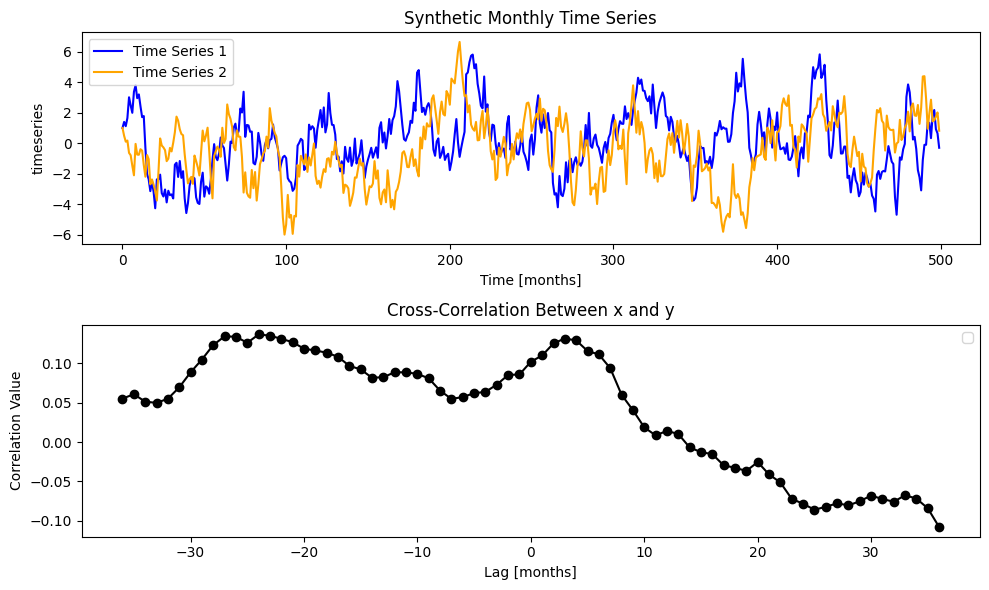

In [7]:
# Plot observed time series
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ts1.da.plot(ax = axes[0], label='Time Series 1', color='blue')
ts2.da.plot(ax = axes[0], label='Time Series 2', color='orange')

axes[0].set_title('Synthetic Monthly Time Series')
axes[0].set_xlabel('Time [months]')
axes[0].legend()

ccf_ds["cross_correlation"].plot(ax=axes[1], color='k', marker='o', zorder=1)

axes[1].set_title('Cross-Correlation Between x and y')
axes[1].set_xlabel('Lag [months]')
axes[1].set_ylabel('Correlation Value')
axes[1].legend()
fig.tight_layout()

### 3. Check correlation significance using two different methods

In [8]:
def plot_significant_correlations(ax, lags, ccf, pvals, alpha=0.05):
    """
    Scatter plot of cross-correlation coefficients, coloring points red if
    their p-value is below `alpha` and black otherwise.

    """
    # Determine colors based on significance threshold
    colors = ['r' if p < alpha else 'k' for p in pvals]
    ax.plot(lags, ccf, c="k", zorder=0)
    ax.scatter(lags, ccf, c=colors, marker='o', zorder=2)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Significance (alpha={alpha})')
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Significant', markerfacecolor='r', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Not Significant', markerfacecolor='k', markersize=8)
    ], loc='best')
    return ax


In [21]:
#### BOOTSTRAPPED (MONTE CARLO) CCF SIGNIFICANCE #####
n_iter = 5000 #number of Monte Carlo Iterations 
bccf_ds = bootstrapped_cross_correlation(ts1, ts2, maxlags=ccf_maxlag, 
                                   n_iter = n_iter, return_distributions = True, detrend = True)

Bootstrapping lags: 100%|██████████| 73/73 [00:16<00:00,  4.35it/s]


[None, None]

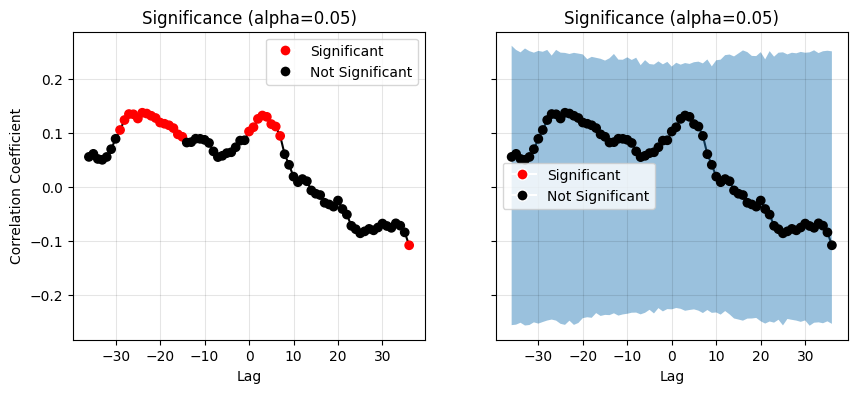

In [40]:
#### GAUSSIAN CCF SIGNIFICANCE #####
ccf_ds = cross_correlation(ts1, ts2, maxlags=ccf_maxlag)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey = True)

axes[0].set_title("Cross Correlation Significance using Gaussian Assumption")
plot_significant_correlations(axes[0], ccf_ds["lag"], ccf_ds["cross_correlation"], ccf_ds["cross_correlation_pvalue"], alpha=0.05)

axes[1].set_title("Cross Correlation Significance using Phase Scrambling")
lb = bccf_ds["bootstrapped_cross_correlation_distribution"].quantile(dim = "bootstrap_iter", q = 0.025)
ub = bccf_ds["bootstrapped_cross_correlation_distribution"].quantile(dim = "bootstrap_iter", q = 0.975)
axes[1].fill_between(ccf_ds["lag"], lb, ub, alpha = 0.45, label = "Bootstrapped 95% Confidence Limits")
plot_significant_correlations(axes[1], bccf_ds["lag"], bccf_ds["bootstrapped_cross_correlation"], bccf_ds["bootstrapped_cross_correlation_pvalue"], alpha=0.05)

axes[1].set_ylabel("")

[a.grid(zorder = 0, alpha = 0.1, c = "k") for a in axes]